## notebook to set up Slingshot workflow

- last updated: 03/26/2024

- reference: https://bioconductor.org/packages/devel/bioc/vignettes/slingshot/inst/doc/vignette.html

### Description: 
This vignette will demonstrate a full single-cell lineage analysis workflow, with particular emphasis on the processes of lineage reconstruction and pseudotime inference. We will make use of the slingshot package proposed in (Street et al. 2017) and show how it may be applied in a broad range of settings.

The goal of slingshot is to use clusters of cells to uncover global structure and convert this structure into smooth lineages represented by one-dimensional variables, called “pseudotime.” We provide tools for learning cluster relationships in an unsupervised or semi-supervised manner and constructing smooth curves representing each lineage, along with visualization methods for each step.

### Overview
The minimal input to slingshot is a matrix representing the cells in a reduced-dimensional space and a vector of cluster labels. With these two inputs, we then:

Identify the global lineage structure by constructing an minimum spanning tree (MST) on the clusters, with the getLineages function.
Construct smooth lineages and infer pseudotime variables by fitting simultaneous principal curves with the getCurves function.
Assess the output of each step with built-in visualization tools.

In [12]:
library(SingleCellExperiment)
library(uwot)
library(mclust, quietly = TRUE)

Package 'mclust' version 6.0.1
Type 'citation("mclust")' for citing this R package in publications.



In [3]:
# generate synthetic count data representing a single lineage
means <- rbind(
    # non-DE genes
    matrix(rep(rep(c(0.1,0.5,1,2,3), each = 300),100),
        ncol = 300, byrow = TRUE),
    # early deactivation
    matrix(rep(exp(atan( ((300:1)-200)/50 )),50), ncol = 300, byrow = TRUE),
    # late deactivation
    matrix(rep(exp(atan( ((300:1)-100)/50 )),50), ncol = 300, byrow = TRUE),
    # early activation
    matrix(rep(exp(atan( ((1:300)-100)/50 )),50), ncol = 300, byrow = TRUE),
    # late activation
    matrix(rep(exp(atan( ((1:300)-200)/50 )),50), ncol = 300, byrow = TRUE),
    # transient
    matrix(rep(exp(atan( c((1:100)/33, rep(3,100), (100:1)/33) )),50), 
        ncol = 300, byrow = TRUE)
)
counts <- apply(means,2,function(cell_means){
    total <- rnbinom(1, mu = 7500, size = 4)
    rmultinom(1, total, cell_means)
})
rownames(counts) <- paste0('G',1:750)
colnames(counts) <- paste0('c',1:300)

sce <- SingleCellExperiment(assays = List(counts = counts))

In [5]:
sce

class: SingleCellExperiment 
dim: 750 300 
metadata(0):
assays(1): counts
rownames(750): G1 G2 ... G749 G750
rowData names(0):
colnames(300): c1 c2 ... c299 c300
colData names(0):
reducedDimNames(0):
mainExpName: NULL
altExpNames(0):

In [6]:
# gene filltering
# filter genes down to potential cell-type markers
# at least M (15) reads in at least N (15) cells
geneFilter <- apply(assays(sce)$counts,1,function(x)n
                    {
    sum(x >= 3) >= 10
})
sce <- sce[geneFilter, ]

In [7]:
# normalization
FQnorm <- function(counts){
    rk <- apply(counts,2,rank,ties.method='min')
    counts.sort <- apply(counts,2,sort)
    refdist <- apply(counts.sort,1,median)
    norm <- apply(rk,2,function(r){ refdist[r] })
    rownames(norm) <- rownames(counts)
    return(norm)
}
assays(sce)$norm <- FQnorm(assays(sce)$counts)

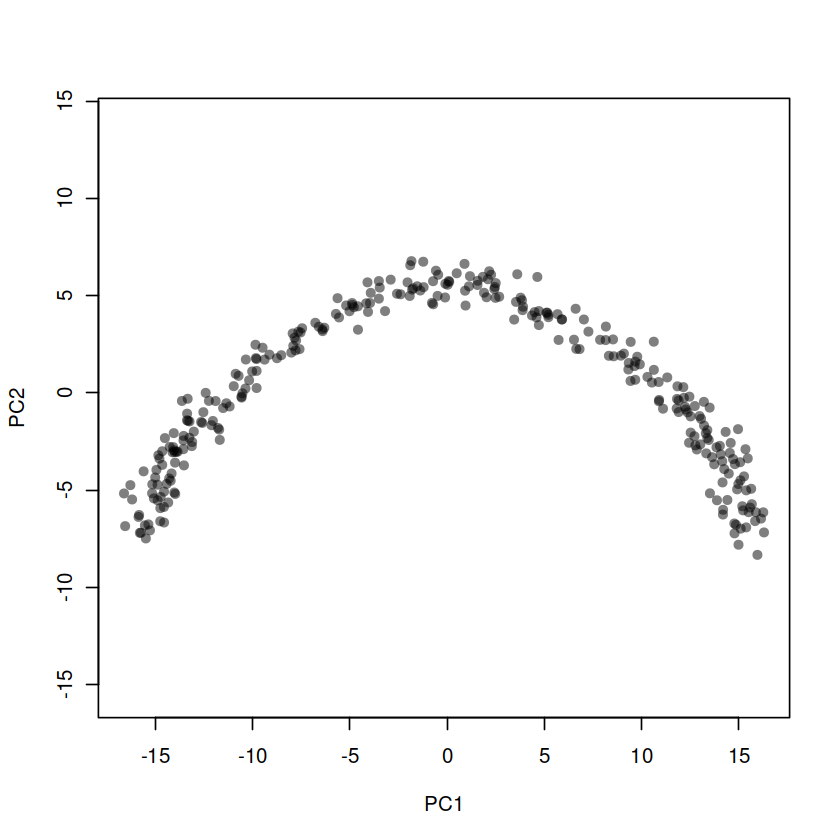

In [8]:
# dim.reduction
pca <- prcomp(t(log1p(assays(sce)$norm)), scale. = FALSE)
rd1 <- pca$x[,1:2]

plot(rd1, col = rgb(0,0,0,.5), pch=16, asp = 1)

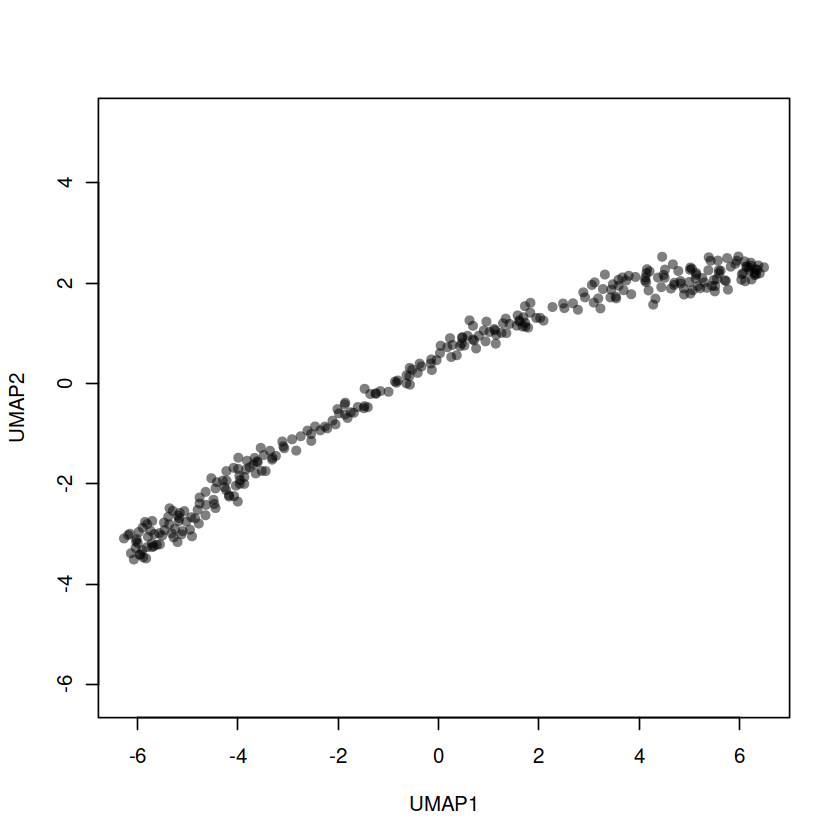

In [10]:
rd2 <- uwot::umap(t(log1p(assays(sce)$norm)))
colnames(rd2) <- c('UMAP1', 'UMAP2')

plot(rd2, col = rgb(0,0,0,.5), pch=16, asp = 1)

We will add both dimensionality reductions to the SingleCellExperiment object, but continue our analysis focusing on the PCA results.

In [11]:
reducedDims(sce) <- SimpleList(PCA = rd1, UMAP = rd2)

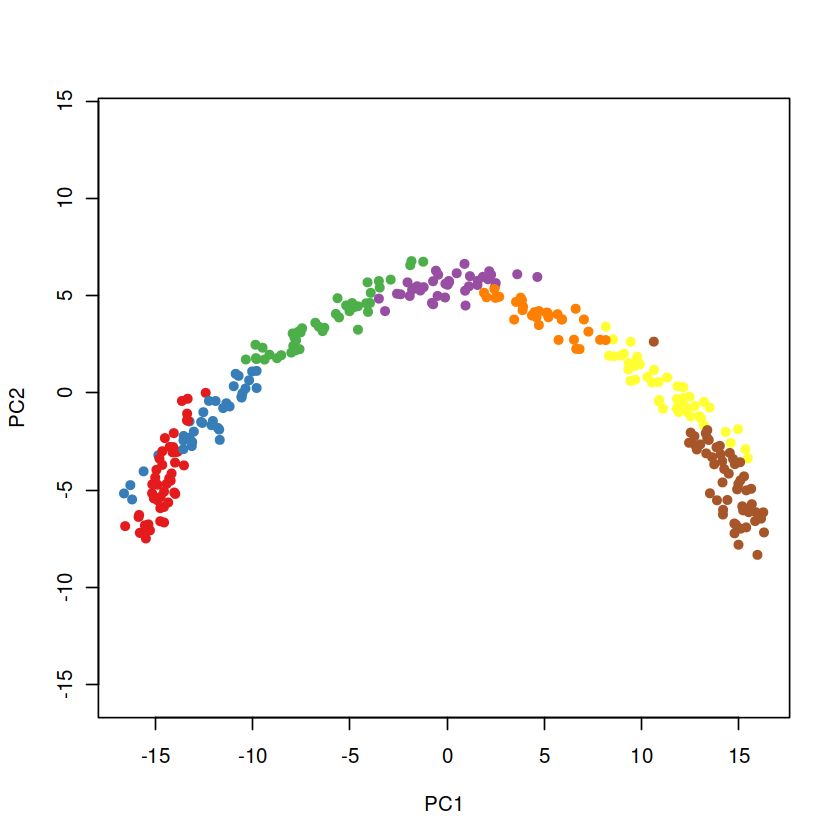

In [13]:
# clustering the cells

cl1 <- Mclust(rd1)$classification
colData(sce)$GMM <- cl1

library(RColorBrewer)
plot(rd1, col = brewer.pal(9,"Set1")[cl1], pch=16, asp = 1)

In [36]:
cl1

c1   c2   c3   c4   c5   c6   c7   c8   c9  c10  c11  c12  c13  c14  c15  c16 
   1    1    1    1    1    1    1    1    1    1    1    1    1    1    1    1 
 c17  c18  c19  c20  c21  c22  c23  c24  c25  c26  c27  c28  c29  c30  c31  c32 
   1    1    2    2    2    1    1    1    1    1    1    1    1    1    1    2 
 c33  c34  c35  c36  c37  c38  c39  c40  c41  c42  c43  c44  c45  c46  c47  c48 
   1    2    1    1    1    1    1    1    1    1    1    1    1    1    1    1 
 c49  c50  c51  c52  c53  c54  c55  c56  c57  c58  c59  c60  c61  c62  c63  c64 
   2    2    2    2    2    1    2    1    2    2    2    2    2    1    2    2 
 c65  c66  c67  c68  c69  c70  c71  c72  c73  c74  c75  c76  c77  c78  c79  c80 
   1    2    2    2    2    1    2    1    2    2    2    2    2    2    2    2 
 c81  c82  c83  c84  c85  c86  c87  c88  c89  c90  c91  c92  c93  c94  c95  c96 
   2    2    2    2    3    3    2    2    3    3    3    3    3    3    3    3 
 c97  c98  c99 c100 c101 c102 c103 c104 c105 c106 c107 c108 c109 c110 c111 c112 
   3    3    3    3    3    3    3    3    3    3    3    3    3    3    3    3 
c113 c114 c115 c116 c117 c118 c119 c120 c121 c122 c123 c124 c125 c126 c127 c128 
   3    3    3    3    3    3    3    3    4    3    3    3    3    3    3    4 
c129 c130 c131 c132 c133 c134 c135 c136 c137 c138 c139 c140 c141 c142 c143 c144 
   4    3    4    3    3    4    3    4    3    4    4    4    4    4    4    4 
c145 c146 c147 c148 c149 c150 c151 c152 c153 c154 c155 c156 c157 c158 c159 c160 
   4    4    4    4    4    4    4    4    4    4    4    4    4    4    4    4 
c161 c162 c163 c164 c165 c166 c167 c168 c169 c170 c171 c172 c173 c174 c175 c176 
   4    4    5    5    5    4    4    5    4    5    5    5    4    4    5    5 
c177 c178 c179 c180 c181 c182 c183 c184 c185 c186 c187 c188 c189 c190 c191 c192 
   5    5    5    5    4    5    5    5    5    5    5    5    5    5    5    5 
c193 c194 c195 c196 c197 c198 c199 c200 c201 c202 c203 c204 c205 c206 c207 c208 
   5    5    5    5    6    5    5    6    5    5    5    6    6    6    6    6 
c209 c210 c211 c212 c213 c214 c215 c216 c217 c218 c219 c220 c221 c222 c223 c224 
   6    6    6    6    6    6    6    7    6    6    6    6    6    6    6    6 
c225 c226 c227 c228 c229 c230 c231 c232 c233 c234 c235 c236 c237 c238 c239 c240 
   6    6    6    6    6    6    6    6    6    6    6    6    6    6    7    6 
c241 c242 c243 c244 c245 c246 c247 c248 c249 c250 c251 c252 c253 c254 c255 c256 
   6    6    6    6    7    7    7    7    7    7    7    7    7    7    6    6 
c257 c258 c259 c260 c261 c262 c263 c264 c265 c266 c267 c268 c269 c270 c271 c272 
   7    6    7    7    7    7    7    6    7    6    7    7    7    7    7    7 
c273 c274 c275 c276 c277 c278 c279 c280 c281 c282 c283 c284 c285 c286 c287 c288 
   7    7    7    7    7    7    7    7    7    7    7    7    7    7    7    7 
c289 c290 c291 c292 c293 c294 c295 c296 c297 c298 c299 c300 
   7    7    7    7    7    7    7    7    7    7    7    7

In [37]:
type(cl1)

[1] "double"

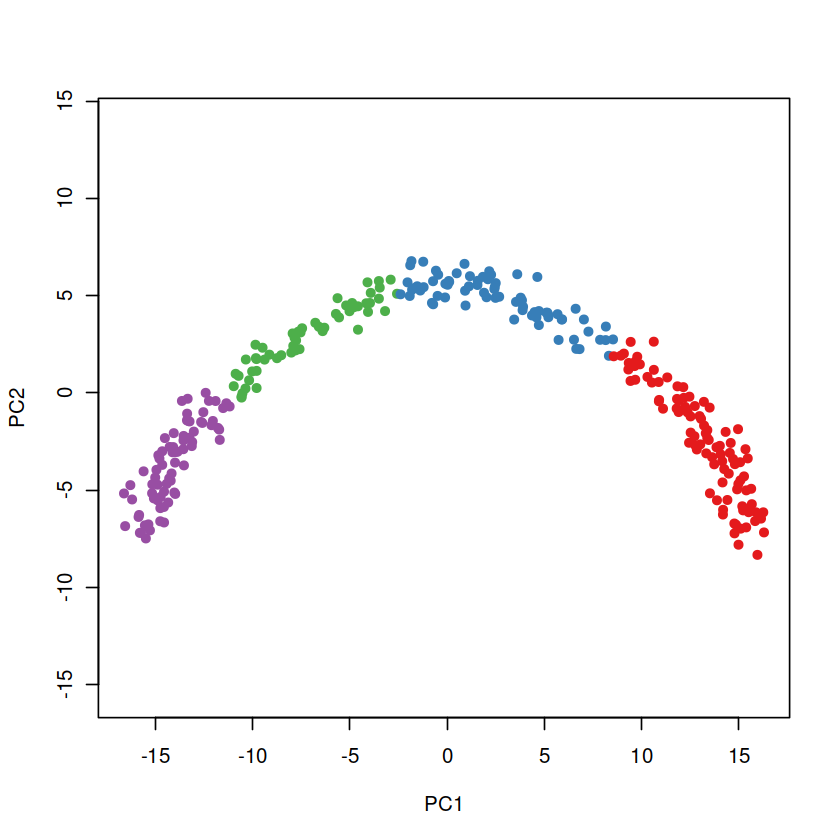

In [14]:
# clustering with k nearest-neighbors
cl2 <- kmeans(rd1, centers = 4)$cluster
colData(sce)$kmeans <- cl2

plot(rd1, col = brewer.pal(9,"Set1")[cl2], pch=16, asp = 1)

In [16]:
library(slingshot, quietly = FALSE)

Loading required package: princurve

Loading required package: TrajectoryUtils



In [17]:
# using Slingshot

sce <- slingshot(sce, clusterLabels = 'GMM', reducedDim = 'PCA')

Warning message:
“useNames = NA is deprecated. Instead, specify either useNames = TRUE or useNames = FALSE.”
Warning message:
“useNames = NA is deprecated. Instead, specify either useNames = TRUE or useNames = FALSE.”
Warning message:
“useNames = NA is deprecated. Instead, specify either useNames = TRUE or useNames = FALSE.”
Warning message:
“useNames = NA is deprecated. Instead, specify either useNames = TRUE or useNames = FALSE.”
Warning message:
“useNames = NA is deprecated. Instead, specify either useNames = TRUE or useNames = FALSE.”
Warning message:
“useNames = NA is deprecated. Instead, specify either useNames = TRUE or useNames = FALSE.”
Warning message:
“useNames = NA is deprecated. Instead, specify either useNames = TRUE or useNames = FALSE.”


In [18]:
sce

class: SingleCellExperiment 
dim: 728 300 
metadata(0):
assays(2): counts norm
rownames(728): G1 G2 ... G749 G750
rowData names(0):
colnames(300): c1 c2 ... c299 c300
colData names(4): GMM kmeans slingshot slingPseudotime_1
reducedDimNames(2): PCA UMAP
mainExpName: NULL
altExpNames(0):

In [19]:
summary(sce$slingPseudotime_1)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   0.00    8.78   21.38   21.41   34.39   43.75 

In [20]:
sce$slingshot@metadata$lineages

$Lineage1
[1] "1" "2" "3" "4" "5" "6" "7"

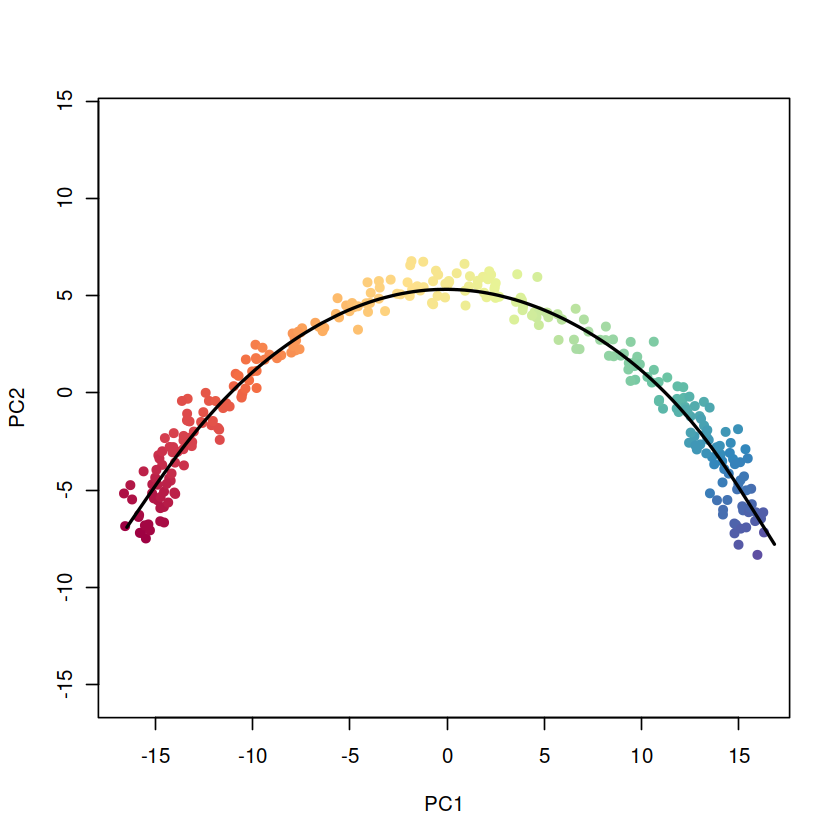

In [21]:
library(grDevices)
colors <- colorRampPalette(brewer.pal(11,'Spectral')[-6])(100)
plotcol <- colors[cut(sce$slingPseudotime_1, breaks=100)]

plot(reducedDims(sce)$PCA, col = plotcol, pch=16, asp = 1)
lines(SlingshotDataSet(sce), lwd=2, col='black')

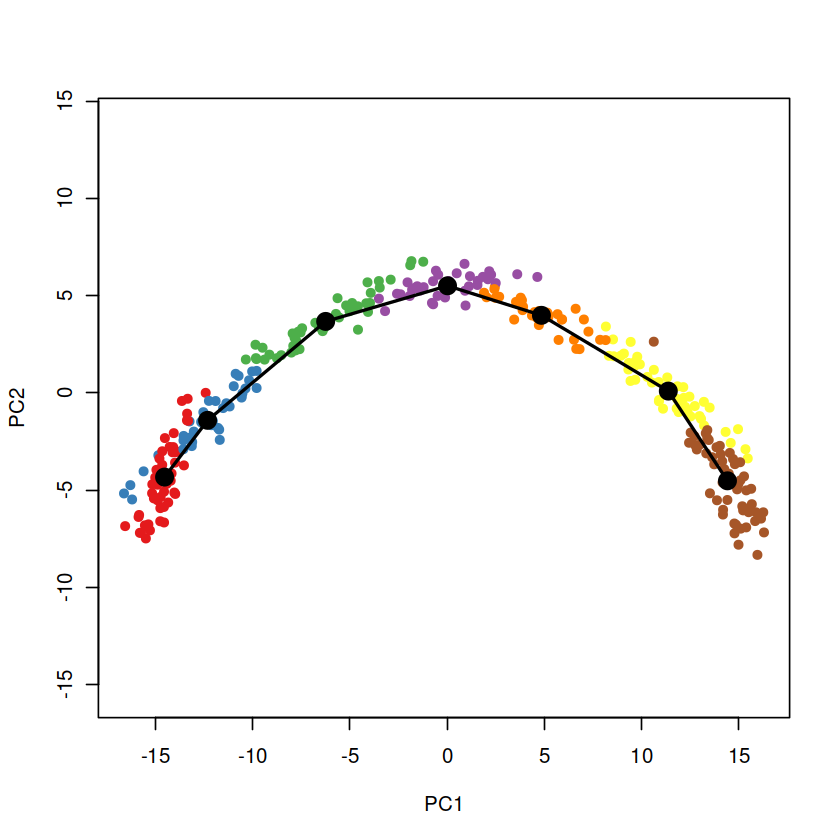

In [22]:
# We can also see how the lineage structure was intially estimated by the cluster-based minimum spanning tree by using the type argument.
plot(reducedDims(sce)$PCA, col = brewer.pal(9,'Set1')[sce$GMM], pch=16, asp = 1)
lines(SlingshotDataSet(sce), lwd=2, type = 'lineages', col = 'black')

## downstream analysis

In [23]:
# Identifying temporally dynamic genes

library(tradeSeq)

# fit negative binomial GAM
sce <- fitGAM(sce)

# test for dynamic expression
ATres <- associationTest(sce)

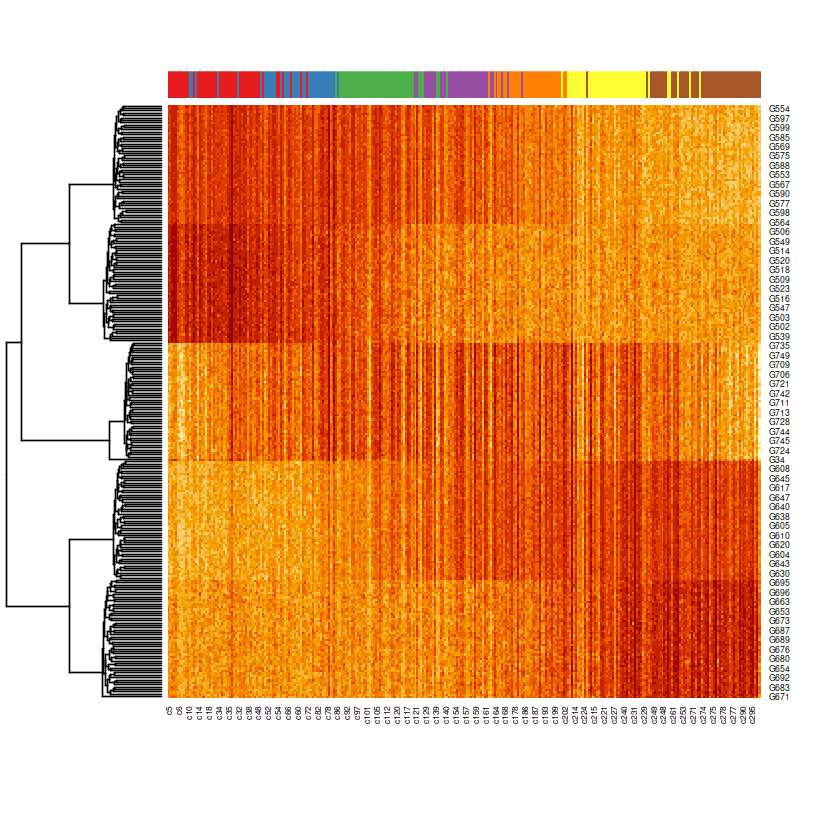

In [24]:
topgenes <- rownames(ATres[order(ATres$pvalue), ])[1:250]
pst.ord <- order(sce$slingPseudotime_1, na.last = NA)
heatdata <- assays(sce)$counts[topgenes, pst.ord]
heatclus <- sce$GMM[pst.ord]

heatmap(log1p(heatdata), Colv = NA,
        ColSideColors = brewer.pal(9,"Set1")[heatclus])

## Advanced

- branching dataset

In [25]:
data("slingshotExample")
# rd means "reduced.dim" - i.e., UMAP
rd <- slingshotExample$rd
# cl means "clustering" - i.e., cell_annotation
cl <- slingshotExample$cl

dim(rd) # data representing cells in a reduced dimensional space

[1] 140   2

In [26]:
lin1 <- getLineages(rd, cl, start.clus = '1')
lin1

Warning message:
“useNames = NA is deprecated. Instead, specify either useNames = TRUE or useNames = FALSE.”
Warning message:
“useNames = NA is deprecated. Instead, specify either useNames = TRUE or useNames = FALSE.”
Warning message:
“useNames = NA is deprecated. Instead, specify either useNames = TRUE or useNames = FALSE.”
Warning message:
“useNames = NA is deprecated. Instead, specify either useNames = TRUE or useNames = FALSE.”
Warning message:
“useNames = NA is deprecated. Instead, specify either useNames = TRUE or useNames = FALSE.”


class: PseudotimeOrdering 
dim: 140 2 
metadata(3): lineages mst slingParams
pathStats(2): pseudotime weights
cellnames(140): cell-1 cell-2 ... cell-139 cell-140
cellData names(2): reducedDim clusterLabels
pathnames(2): Lineage1 Lineage2
pathData names(0):

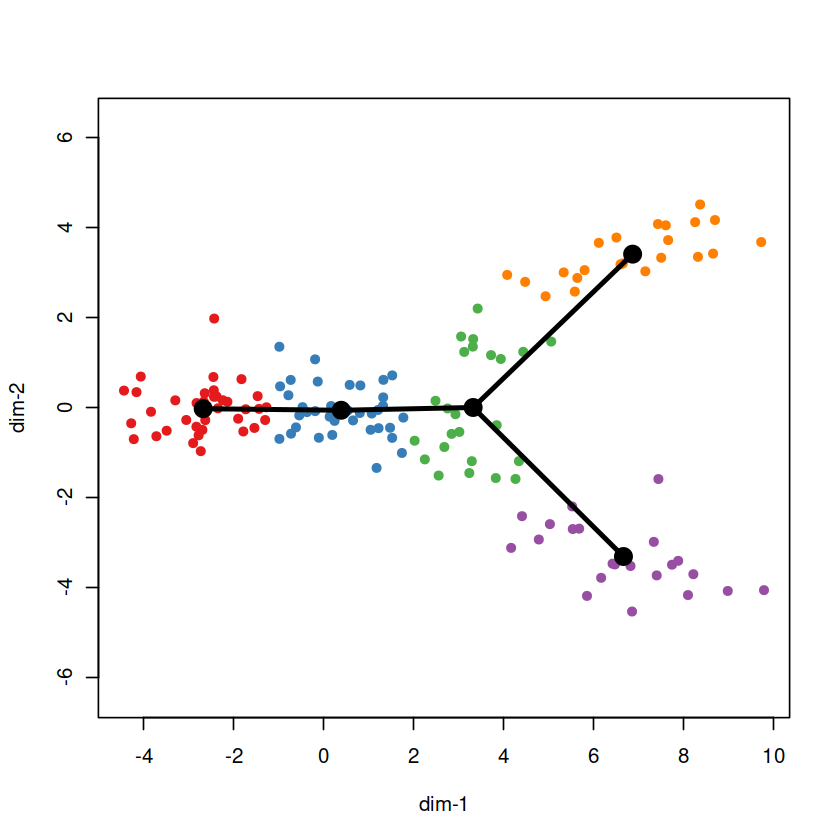

In [32]:
plot(rd, col = brewer.pal(9,"Set1")[cl], asp = 1, pch = 16)
lines(SlingshotDataSet(lin1), lwd = 3, col = 'black')

Warning message:
“useNames = NA is deprecated. Instead, specify either useNames = TRUE or useNames = FALSE.”
Warning message:
“useNames = NA is deprecated. Instead, specify either useNames = TRUE or useNames = FALSE.”
Warning message:
“useNames = NA is deprecated. Instead, specify either useNames = TRUE or useNames = FALSE.”
Warning message:
“useNames = NA is deprecated. Instead, specify either useNames = TRUE or useNames = FALSE.”
Warning message:
“useNames = NA is deprecated. Instead, specify either useNames = TRUE or useNames = FALSE.”


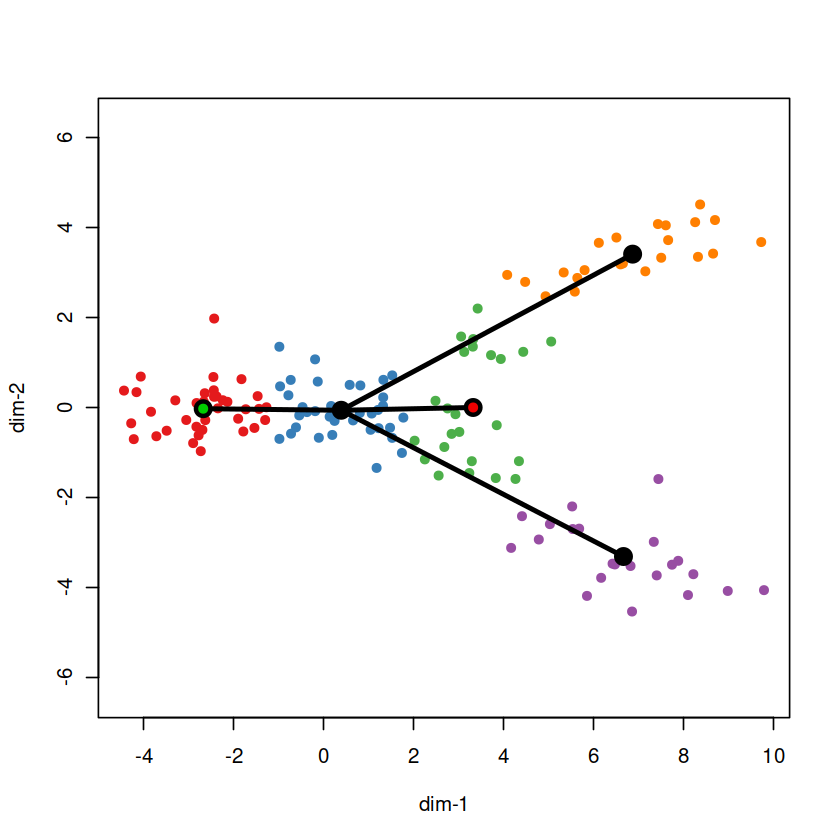

In [33]:
lin2 <- getLineages(rd, cl, start.clus= '1', end.clus = '3')

plot(rd, col = brewer.pal(9,"Set1")[cl], asp = 1, pch = 16)
lines(SlingshotDataSet(lin2), lwd = 3, col = 'black', show.constraints = TRUE)

In [ ]:
sessionInfo()